In [75]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.metrics import accuracy_score

In [76]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [77]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [78]:
print("X_train.shape :" ,X_train.shape)
print("y_train.shape :", y_train.shape)
print ("X_test.shape :" , X_test.shape)
print("y_test.shape :", y_test.shape)

X_train.shape : (60000, 28, 28)
y_train.shape : (60000,)
X_test.shape : (10000, 28, 28)
y_test.shape : (10000,)


In [79]:
X_train = X_train / 255.0

In [80]:
X_train = X_train.reshape((60000,28*28))
X_test = X_test.reshape((10000, 28*28))

In [81]:
y_train = y_train.reshape((60000,1))
y_test = y_test.reshape((10000,1))

In [82]:
print("X_train.shape :" ,X_train.shape)
print("y_train.shape :", y_train.shape)
print ("X_test.shape :" , X_test.shape)
print("y_test.shape :", y_test.shape)

X_train.shape : (60000, 784)
y_train.shape : (60000, 1)
X_test.shape : (10000, 784)
y_test.shape : (10000, 1)


In [94]:
#Check that we have balnced data
unique, counts = np.unique(y_train, return_counts=True)
print("y_train :", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("y_test :", dict(zip(unique, counts)))

y_train : {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
y_test : {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


##  Models:

We will try several models and in the end we will decide which is the best model.<br>
We will try the following models:
* Random Forest
* KNN

In [65]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_train)
print("The DummyClassifier score is:" ,dummy_clf.score(X_test, y_test))

The DummyClassifier score is: 0.1


In [66]:
from sklearn.metrics import classification_report
from sklearn import metrics

In [112]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier().fit(X_train, y_train)
y_pred = KNN.predict(X_test)
precision = round(metrics.precision_score(y_test, y_pred, average="weighted"),3)            
accuracy = round(metrics.accuracy_score(y_test, y_pred),3)
print("precision_score:", precision)
print("Accuracy:", accuracy)
print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

precision_score: 0.397
Accuracy: 0.321
Classification Report: 
               precision    recall  f1-score   support

           0       0.49      0.74      0.59      1000
           1       0.99      0.36      0.53      1000
           2       0.23      0.85      0.36      1000
           3       0.69      0.10      0.17      1000
           4       0.50      0.22      0.31      1000
           5       0.00      0.00      0.00      1000
           6       0.27      0.12      0.16      1000
           7       0.00      0.00      0.00      1000
           8       0.15      0.42      0.22      1000
           9       0.64      0.41      0.50      1000

    accuracy                           0.32     10000
   macro avg       0.40      0.32      0.28     10000
weighted avg       0.40      0.32      0.28     10000



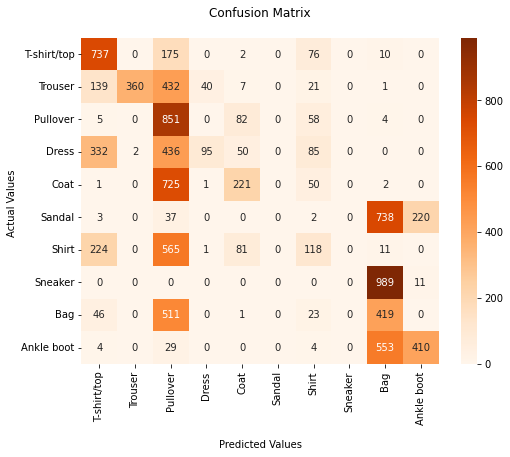

In [106]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Oranges')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"],rotation=90)
ax.yaxis.set_ticklabels(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"],rotation=0)

plt.show()

In [107]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = RF.predict(X_test)
accuracy = round(metrics.accuracy_score(y_test, y_pred),3)
print("Accuracy:", accuracy)
print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

Accuracy: 0.694
Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.35      0.48      1000
           1       0.89      0.91      0.90      1000
           2       0.43      0.73      0.54      1000
           3       0.80      0.74      0.77      1000
           4       0.48      0.25      0.33      1000
           5       0.98      0.86      0.91      1000
           6       0.33      0.48      0.39      1000
           7       0.88      0.80      0.84      1000
           8       0.93      0.85      0.89      1000
           9       0.81      0.96      0.88      1000

    accuracy                           0.69     10000
   macro avg       0.73      0.69      0.69     10000
weighted avg       0.73      0.69      0.69     10000



In [108]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

XGB = XGBClassifier().fit(X_train, y_train)
y_pred = XGB.predict(X_test)

precision = round(metrics.precision_score(y_test, y_pred, average="weighted"),3)            
accuracy = round(metrics.accuracy_score(y_test, y_pred),3)
print("precision_score:", precision)
print("Accuracy:", accuracy)
print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

[16:07:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
precision_score: 0.788
Accuracy: 0.772
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.68      0.73      1000
           1       0.85      0.97      0.91      1000
           2       0.63      0.58      0.61      1000
           3       0.92      0.74      0.82      1000
           4       0.54      0.76      0.63      1000
           5       0.99      0.87      0.92      1000
           6       0.50      0.49      0.49      1000
           7       0.96      0.77      0.86      1000
           8       0.86      0.89      0.87      1000
           9       0.82      0.98      0.89      1000

    accuracy                 

In [15]:
#Searching for better performance out of the models with RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV